<a href="https://colab.research.google.com/github/SaketMunda/introduction-to-nlp/blob/master/skimlit_nlp_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit NLP Milestone Project : Exercises

1. Train `model_5` on all of the data in the training dataset for as many epochs until it stops improving. Since this might take a while, you might want to use:
  - [tf.keras.callbacks.ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) to save the model's best weights only.
  - [tf.keras.callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to stop the model from training once the validation loss has stopped improving for ~3 epochs.
2. Checkout the [Keras guide on using pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/). Can you get this working with one of our models?
  - Hint: You'll want to incorporate it with a custom token [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.
  - It's up to you whether or not you fine-tune the GloVe embeddings or leave them frozen.
3. Try replacing the TensorFlow Hub Universal Sentence Encoder pretrained embedding for the [TensorFlow Hub BERT PubMed expert](https://tfhub.dev/google/experts/bert/pubmed/2) (a language model pretrained on PubMed texts) pretrained embedding. Does this effect results?
  - Note: Using the BERT PubMed expert pretrained embedding requires an extra preprocessing step for sequences (as detailed in the [TensorFlow Hub guide](https://tfhub.dev/google/experts/bert/pubmed/2)).
  - Does the BERT model beat the results mentioned in this paper? https://arxiv.org/pdf/1710.06071.pdf
4. What happens if you were to merge our `line_number` and `total_lines` features for each sequence? For example, created a `X_of_Y` feature instead? Does this effect model performance?
  - Another example: `line_number=1` and `total_lines=11` turns into `line_of_X=1_of_11`.
5. Write a function (or series of functions) to take a sample abstract string, preprocess it (in the same way our model has been trained), make a prediction on each sequence in the abstract and return the abstract in the format:
  - `PREDICTED_LABEL`: `SEQUENCE`
  - `PREDICTED_LABEL`: `SEQUENCE`
  - `PREDICTED_LABEL`: `SEQUENCE`
  - `PREDICTED_LABEL`: `SEQUENCE`
  - `...`
    - You can find your own unstrcutured RCT abstract from PubMed or try this one from: [Baclofen promotes alcohol abstinence in alcohol dependent cirrhotic patients with hepatitis C virus (HCV) infection](https://pubmed.ncbi.nlm.nih.gov/22244707/).

In [3]:
# check the gpu
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-60093581-201a-3d8e-80ff-31653e9161d9)


In [4]:
# import helper function
!wget https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py

from helper_functions import create_tensorboard_callback

--2023-03-18 03:51:42--  https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2904 (2.8K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   2.84K  --.-KB/s    in 0s      

2023-03-18 03:51:42 (46.9 MB/s) - ‘helper_functions.py’ saved [2904/2904]



## Get the Data


In [5]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 9.63 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [6]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [7]:
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocessing Data

### Transform Data

Since our data is in txt format, we need to convert it into some dataframe for further training and modelling experiments.

In [8]:
def get_lines(filename):
  """
  Reads a filename(.txt) and returns the lines of text as a list.
  """
  with open(filename, 'r') as file:
    return file.readlines()

In [7]:
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Now we have to write a function which can transform the labels associated with the sentence in one column, the text in another column and also few other details like line_number and total_lines.

In a format like,

```
[
  {
    'line_number':0,
    'target': 'OBJECTIVE',
    'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .'
    'total_lines':11
  }
]
```

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns the list of dictionaries of abstract line data.

  Takes the filename as input, reads it contents and sort through each line, 
  extracting things like the target label, text of the sentence, how many lines
  in that abstract and what sentence number the target line is.
  """

  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1 # starting from 0
        abstract_samples.append(line_data)
    else:
      abstract_lines+=line
  
  return abstract_samples

In [10]:
# get the data from files and preprocess it
%%time

train_samples = preprocess_text_with_line_numbers(data_dir+'train.txt')
test_samples = preprocess_text_with_line_numbers(data_dir+'test.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'dev.txt')

len(train_samples), len(test_samples), len(val_samples)

CPU times: user 356 ms, sys: 81.2 ms, total: 438 ms
Wall time: 440 ms


(180040, 30135, 30212)

In [ ]:
train_samples[:12]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now let's convert them into `pandas` dataframe

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)

train_df.shape

(180040, 4)

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

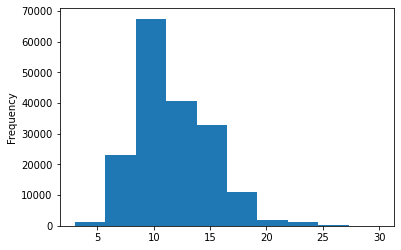

In [ ]:
train_df.total_lines.plot.hist()

### Get the list of sentences


In [12]:
train_sentences = train_df.text.tolist()
test_sentences = test_df.text.tolist()
val_sentences = val_df.text.tolist()

train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels

In [13]:
## one hot encoded
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [14]:
# get the class names and number of classes from OneHotEncoder instance
num_classes = len(one_hot_encoder.categories_[0])
class_names = one_hot_encoder.categories_[0]

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### OneHotEncode `line_number` and `total_lines`

In [15]:
import tensorflow as tf
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)

train_line_number_one_hot[:10], train_line_number_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [16]:
# same with total lines
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Convert Sentences into Characters

In [17]:
def split_chars(text):
  return " ".join(list(text))

In [18]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]

train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

## Exercise 1: Train `model_5` for as many epochs until it stops improving

In [ ]:
# let's load the model
drive_path = 'drive/MyDrive/Data Science/SkimLit/skimlit_tribrid_model'

model = tf.keras.models.load_model(drive_path)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

So first we need to create few things for further training,
- Create a prefetched dataset using `tf.Data.Dataset` API of tensorflow
- ModelCheckpoint using `tf.keras.callbacks.ModelCheckpoint`
- EarlyStopping using `tf.keras.callbacks.EarlyStopping`

In [ ]:
# Prefetch Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                    train_total_lines_one_hot,
                                                    train_sentences,
                                                    train_chars))
train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_dataset = tf.data.Dataset.zip((train_data, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
val_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                               val_total_lines_one_hot,
                                               val_sentences,
                                               val_chars))
val_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))

val_dataset = tf.data.Dataset.zip((val_data, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)


test_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                test_total_lines_one_hot,
                                                test_sentences,
                                                test_chars))

test_labels = tf.data.Dataset.from_tensor_slices((test_labels_one_hot))

test_dataset = tf.data.Dataset.zip((test_data, test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# model checkpoint callback
filepath = 'model_logs/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                               monitor='val_loss',
                                                               save_weights_only=True,
                                                               save_best_only=True,
                                                               mode='min',
                                                               save_freq = 'epoch')

# early stopping callback
model_early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                 patience=3)

Great ! Now we can first compile the loaded model and then we can fit the model with callbacks to see the results.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    epochs=50,                    
                    validation_data=val_dataset,
                    validation_steps=int(0.1 * len(val_dataset)),
                    callbacks=[create_tensorboard_callback('model_logs/tensorboard','model_exercise_1'),
                               model_checkpoint_callback,
                               model_early_stopping_callback])

Saving Tensorboard log files to: model_logs/tensorboard/model_exercise_1/20230316-040934
Epoch 1/50
5627/5627 [==============================] - 194s 32ms/step - loss: 0.3945 - accuracy: 0.8506 - val_loss: 0.3671 - val_accuracy: 0.8574
Epoch 2/50
5627/5627 [==============================] - 176s 31ms/step - loss: 0.3519 - accuracy: 0.8686 - val_loss: 0.3506 - val_accuracy: 0.8630
Epoch 3/50
5627/5627 [==============================] - 182s 32ms/step - loss: 0.3298 - accuracy: 0.8773 - val_loss: 0.3482 - val_accuracy: 0.8624
Epoch 4/50
5627/5627 [==============================] - 183s 33ms/step - loss: 0.3145 - accuracy: 0.8822 - val_loss: 0.3472 - val_accuracy: 0.8670
Epoch 5/50
5627/5627 [==============================] - 179s 32ms/step - loss: 0.3008 - accuracy: 0.8867 - val_loss: 0.3520 - val_accuracy: 0.8677
Epoch 6/50
5627/5627 [==============================] - 178s 32ms/step - loss: 0.2897 - accuracy: 0.8910 - val_loss: 0.3531 - val_accuracy: 0.8660
Epoch 7/50
5627/5627 [=======

In [ ]:
# lets evaluate on validation data
model.evaluate(val_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.3631 - accuracy: 0.8668


[0.36314550042152405, 0.8668410181999207]

## Exercise 2 : Using pretrained GloVe embeddings

### Text Vectorizer Layer

In [57]:
# identify the average sentence length of training data
import numpy as np
sentence_length = [len(sentence.split()) for sentence in train_sentences]
avg_sent_length = np.mean(sentence_length)
avg_sent_length

26.338269273494777

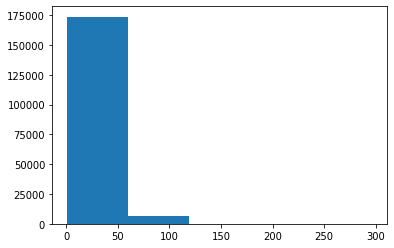

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sentence_length, bins=5);

Looks like majority of sentences are between 0 and 50 tokens in length.

We can use Numpy's percentile to find the value which covers 95% of the sentence lengths.

In [58]:
output_seq_len = int(np.percentile(sentence_length, 95))
output_seq_len

55

Also according to the [PubMed 200K RCT Paper](https://arxiv.org/pdf/1710.06071.pdf), the vocabulary size of the PubMed 20K dataset should be 68,000, so i.e our `max_tokens` value in TextVectorization

In [59]:
max_tokens = 68000

from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=output_seq_len)

In [60]:
# adapt the training samples
vectorizer.adapt(train_sentences)

Get information from our `vectorizer` of `train_sentences`

In [61]:
vocab = vectorizer.get_vocabulary()

print(f'Number of vocabulary in training sentences:{len(vocab)}')
print(f'\nMost common words in the vocabulary:{vocab[:5]}')
print(f'\nLeast common words in the vocabulary:{vocab[-5:]}')

Number of vocabulary in training sentences:64841

Most common words in the vocabulary:['', '[UNK]', 'the', 'and', 'of']

Least common words in the vocabulary:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### Create pretrained GloVe embedding layer

https://keras.io/examples/nlp/pretrained_word_embeddings/

In [ ]:
# load the pretrained embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-03-17 03:41:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-03-17 03:41:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-03-17 03:41:14--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

The zip file contains text-encoded vectors of various sizes: 50 dimensional, 100 dimensional, 200 dimensional, 300 dimensional. We'll use 100D ones first.



In [ ]:
glove_filename = 'glove.6B.100d.txt'

embeddings_index = {}
with open(glove_filename, 'r') as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs,'f', sep=" ")
    embeddings_index[word] = coefs

len(embeddings_index)

400000

Let's see the embeddings of 5 most common words of our vocabulary in glove embedding

In [ ]:
common_words = vocab[:5]
common_words

['', '[UNK]', 'the', 'and', 'of']

In [ ]:
for word in common_words:
  if word in embeddings_index.keys():
    print(f"\nEmbedding of '{word}':\n {embeddings_index[word]}")
  else:
    print(f"\nEmbedding doesn't exist of {word}")


Embedding doesn't exist of 

Embedding doesn't exist of [UNK]

Embedding of 'the':
 [-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.0

So now, we have to prepare a corresponding embedding matrix that we can use in Keras `Embedding` layer. It's a simple Numpy matrix where entry at `index i` is the pre-trained vector for the word of `index i` in our vectorizer's vocabulary.

In [ ]:
# it will create the index of all the words in the vocabulary
word_index = dict(zip(vocab, range(len(vocab))))

In [ ]:
num_tokens = len(vocab) + 2
output_dim = 100
hits = 0
misses = 0

# prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, output_dim))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # Words not found in embedding index will be all-zeroes
    # This include the representation for "OOV" and "padding"
    embedding_matrix[i] = embedding_vector
    hits += 1
  else:
    misses += 1

print(f'Converted {hits} words ({misses} misses)')

Converted 29730 words (35111 misses)


Lot's of misses, anyways let's create the `Embedding Layer`

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

embedding_layer = layers.Embedding(
    input_dim=num_tokens,
    output_dim=output_dim,
    mask_zero=True,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable=False # freezing the embeddings, not updating the values while training
    )

Let's try in any one of the random `train_sentences`

In [ ]:
import random
sample_sentence = random.choice(train_sentences)

print(f'Sentence before embedding:\n{sample_sentence}')
vectorized_sentence= vectorizer([sample_sentence])
print(f'\nVectorized Sentence:\n{vectorized_sentence}')
embedded_sentence = embedding_layer(vectorized_sentence)
print(f'\nSentence after embedding:\n{embedded_sentence}')
print(f'\nEmbedded Sentence Shape:{embedded_sentence.shape}')

Sentence before embedding:
the ideal duration of modified ultrafiltration has not been established yet .

Vectorized Sentence:
[[   2 3913  282    4  599 6582  139   31  167 1016 1337    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.038194 -0.24487   0.72812  ... -0.1459    0.8278    0.27062 ]
  [ 0.021146  0.3907    0.40079  ... -0.71329   0.077824  0.62242 ]
  [-0.3765    0.18407  -0.23377  ...  0.33156   0.04296  -0.44148 ]
  ...
  [ 0.        0.        0.       ...  0.        0.        0.      ]
  [ 0.        0.        0.       ...  0.        0.        0.      ]
  [ 0.        0.        0.       ...  0.        0.        0.      ]]]

Embedded Sentence Shape:(1, 55, 100)


### Creating Prefetch Dataset

In [19]:
train_dataset_ex_2 = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset_ex_2 = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_ex_2 = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset_ex_2

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Create & Build the Model

In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
text_vectorizer = vectorizer(inputs)
pretrained_embed = embedding_layer(text_vectorizer)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(pretrained_embed)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name='experiment_2_pretrained_glove')

# compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_2.summary()

Model: "experiment_2_pretrained_glove"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 55, 100)           6484300   
                                                                 
 conv1d_4 (Conv1D)           (None, 55, 64)            32064     
                                                                 
 global_average_pooling1d_4   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 5

In [ ]:
# fit the model
history_2 = model_2.fit(train_dataset_ex_2,
                        steps_per_epoch=int(0.1 * len(train_dataset_ex_2)),
                        epochs=3,
                        validation_data=val_dataset_ex_2,
                        validation_steps=int(0.1 * len(val_dataset_ex_2)))

Epoch 1/3
562/562 [==============================] - 13s 5ms/step - loss: 1.0442 - accuracy: 0.5974 - val_loss: 0.9611 - val_accuracy: 0.6350
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.8981 - accuracy: 0.6535 - val_loss: 0.8861 - val_accuracy: 0.6586
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.8633 - accuracy: 0.6714 - val_loss: 0.8496 - val_accuracy: 0.6892


We can further train with more epochs and also add more conv layers and pooling layer in the process of fine-tuning to obtain better metrics results.

## Exercise 3 : Use Tensorflow Hub BERT instead of USE

Try replacing the TensorFlow Hub Universal Sentence Encoder pretrained embedding for the [TensorFlow Hub BERT PubMed expert](https://tfhub.dev/google/experts/bert/pubmed/2) (a language model pretrained on PubMed texts) pretrained embedding. Does this effect results?
  - Note: Using the BERT PubMed expert pretrained embedding requires an extra preprocessing step for sequences (as detailed in the [TensorFlow Hub guide](https://tfhub.dev/google/experts/bert/pubmed/2)).
  - Does the BERT model beat the results mentioned in this paper? https://arxiv.org/pdf/1710.06071.pdf

### Create pretrained BERT PubMed expert layer

In [20]:
!pip3 install --quiet tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 32.6 MB/s eta 0:00:00


In [21]:
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import layers

# Load the Bert encoder ad preprocessing models
bert_preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
                                          trainable=False,
                                          name='bert_preprocessing_layer')

bert_layer = hub.KerasLayer('https://tfhub.dev/google/experts/bert/pubmed/2',
                            trainable=False,
                            name='bert_model_layer')

For prefetched dataset we will use the same as `Experiment 2` i.e `train_dataset_exp_2`

### Build and Fit the BERT model

In [22]:
input = layers.Input(shape=[], dtype=tf.string, name='input_sentences')
bert_inputs = bert_preprocessing_layer(input)
bert_embedding = bert_layer(bert_inputs)
print(f'bert embedding shape: {bert_embedding}')
x = layers.Dense(128, activation='relu')(bert_embedding['pooled_output'])
x = layers.Dropout(0.5)(x)
output = layers.Dense(num_classes, activation='softmax')(x)

pubmed_bert_model = tf.keras.Model(input, output)
pubmed_bert_model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


bert embedding shape: {'default': <KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'bert_model_layer')>, 'sequence_output': <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, 'encoder_outputs': [<KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(N

In [23]:
# compile the model
pubmed_bert_model.compile(loss='categorical_crossentropy',
                          optimizer='Adam',
                          metrics=['accuracy'])

# fit the model
history_bert = pubmed_bert_model.fit(train_dataset_ex_2,
                                     epochs=3,
                                     steps_per_epoch=int(0.1 * len(train_dataset_ex_2)),
                                     validation_data=val_dataset_ex_2,
                                     validation_steps=int(0.1 * len(val_dataset_ex_2)))

Epoch 1/3
562/562 [==============================] - 252s 423ms/step - loss: 0.6534 - accuracy: 0.7740 - val_loss: 0.4420 - val_accuracy: 0.8454
Epoch 2/3
562/562 [==============================] - 237s 422ms/step - loss: 0.5218 - accuracy: 0.8189 - val_loss: 0.4331 - val_accuracy: 0.8431
Epoch 3/3
562/562 [==============================] - 227s 404ms/step - loss: 0.5006 - accuracy: 0.8255 - val_loss: 0.4170 - val_accuracy: 0.8570


In [24]:
# evaluate the model
pubmed_bert_model.evaluate(val_dataset_ex_2)

945/945 [==============================] - 336s 355ms/step - loss: 0.4123 - accuracy: 0.8517


[0.4123277962207794, 0.8516814708709717]

## Exercise 4 : Convert the `line_number` and `total_lines` feature into `X_of_Y`

What happens if you were to merge our `line_number` and `total_lines` features for each sequence? For example, created a `X_of_Y` feature instead? Does this effect model performance?
  - Another example: `line_number=1` and `total_lines=11` turns into `line_of_X=1_of_11`.

In [25]:
# let's first view data
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [26]:
train_df['line_number_total'] = train_df['line_number'].astype(str) + '_of_' + train_df['total_lines'].astype(str)
val_df['line_number_total'] = train_df['line_number'].astype(str) + '_of_' + train_df['total_lines'].astype(str)

train_df.head()

,target,text,line_number,total_lines,line_number_total
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11,0_of_11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11,1_of_11
2,METHODS,outcome measures included pain reduction and i...,2,11,2_of_11
3,METHODS,pain was assessed using the visual analog pain...,3,11,3_of_11
4,METHODS,secondary outcome measures included the wester...,4,11,4_of_11


In [29]:
train_df.dtypes

target               object
text                 object
line_number           int64
total_lines           int64
line_number_total    object
dtype: object

### OneHot Encode

In [62]:
# one hot encode the new feature
from sklearn.preprocessing import OneHotEncoder
import numpy as np

one_hot_encoder = OneHotEncoder()

# Fitting the onehotencoder
one_hot_encoder.fit(np.expand_dims(train_df['line_number_total'], axis=1))

# Transforming both train and val df
train_line_number_total_encoded = one_hot_encoder.transform(np.expand_dims(train_df['line_number_total'], axis=1))
val_line_number_total_encoded = one_hot_encoder.transform(np.expand_dims(val_df['line_number_total'], axis=1))

# checking the shapes
train_line_number_total_encoded.shape, val_line_number_total_encoded.shape

((180040, 460), (30212, 460))

In [63]:
train_line_number_total_encoded[0]

<1x460 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [64]:
# Converting the sparse matrix to array
train_line_number_total_encoded = train_line_number_total_encoded.toarray()
val_line_number_total_encoded = val_line_number_total_encoded.toarray()

train_line_number_total_encoded[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [65]:
# converting the dtype to int
train_line_number_total_encoded= tf.cast(train_line_number_total_encoded, dtype=tf.float32)
val_line_number_total_encoded= tf.cast(val_line_number_total_encoded, dtype=tf.float32)

In [44]:
type(train_line_number_total_encoded)

tensorflow.python.framework.ops.EagerTensor

In [67]:
train_line_number_total_encoded.shape

TensorShape([180040, 460])

### Prefetch dataset

In [73]:
train_data_exp_4 = tf.data.Dataset.from_tensor_slices((train_line_number_total_encoded,
                                                       train_sentences,
                                                       train_chars))
train_labels_exp_4 = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))

train_dataset_exp_4 = tf.data.Dataset.zip((train_data_exp_4, train_labels_exp_4)).batch(32).prefetch(tf.data.AUTOTUNE)


val_data_exp_4 = tf.data.Dataset.from_tensor_slices((val_line_number_total_encoded,
                                                     val_sentences,
                                                     val_chars))
val_labels_exp_4 = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))

val_dataset_exp_4 = tf.data.Dataset.zip((val_data_exp_4, val_labels_exp_4)).batch(32).prefetch(tf.data.AUTOTUNE)


train_dataset_exp_4

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 460), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Create Character Level Tokenizer and Embedding

In [46]:
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [47]:
# identify the maximum character length
char_len = [len(sentence) for sentence in train_sentences]
mean_char_length = np.mean(char_len)
mean_char_length

149.3662574983337

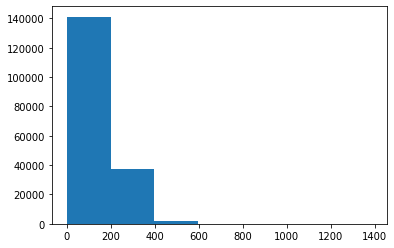

In [49]:
import matplotlib.pyplot as plt
plt.hist(char_len, bins=7);

It looks like the majority of sentences have char_len is between 0-400

In [50]:
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

290

In [51]:
import string
alphabet = string.ascii_lowercase + string.punctuation + string.digits
alphabet

'abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789'

In [52]:
from tensorflow.keras.layers import TextVectorization

NUM_CHAR_TOKENS = len(alphabet) + 2

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name='char_vectorizer')
char_vectorizer.adapt(train_chars)

In [53]:
char_vocab = char_vectorizer.get_vocabulary()

print(f'Number of different characters:{len(char_vocab)}')
print(f'Number of most common chars:{char_vocab[:5]}')
print(f'Number of least common chars:{char_vocab[-5:]}')

Number of different characters:28
Number of most common chars:['', '[UNK]', 'e', 't', 'i']
Number of least common chars:['k', 'x', 'z', 'q', 'j']


Now we have to create an Embedding Layer

In [56]:
from tensorflow.keras.layers import Embedding

char_embed = Embedding(input_dim=NUM_CHAR_TOKENS,
                       output_dim=25,
                       mask_zero=False,
                       name='char_embedding')

### Create the model

In [69]:
# 1. Token Inputs (using BERT model as a layer)
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_preprocess_bert = bert_preprocessing_layer(token_inputs)
token_embedded_bert = bert_layer(token_preprocess_bert)
token_outputs = layers.Dense(128, activation='relu')(token_embedded_bert['pooled_output'])
token_model = tf.keras.Model(token_inputs, token_outputs)


# 2. Char Inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embedded = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embedded)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)


# 3. Line NUmber Total inputs
line_number_total_inputs = layers.Input(shape=(460,), dtype=tf.float32, name='line_number_totals')
x = layers.Dense(64, activation='relu')(line_number_total_inputs)
line_number_total_model = tf.keras.Model(line_number_total_inputs, x)

# 4. Combine outputs of 1 and 2
combined_embeddings = layers.Concatenate(name='token_char_embeddings')([token_model.output,
                                                                        char_model.output])

z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)


# Combine outputs of 3 and 4
z = layers.Concatenate(name='token_char_line_number_totals_embeddings')([line_number_total_model.output,
                                                                         z])

# Create an output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(z)
model_4 = tf.keras.Model(inputs=[line_number_total_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name='model_4_tribrid_model')

In [71]:
model_4.summary()

Model: "model_4_tribrid_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 bert_preprocessing_layer (Kera  {'input_mask': (Non  0          ['token_inputs[0][0]']           
 sLayer)                        e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                  

In [72]:
# let's compile the model
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer='Adam',
                metrics=['accuracy'])

In [74]:
history_4 = model_4.fit(train_dataset_exp_4,
                        epochs=3,
                        steps_per_epoch=int(0.1 * len(train_dataset_exp_4)),
                        validation_data=val_dataset_exp_4,
                        validation_steps=int(0.1 * len(val_dataset_exp_4)))

Epoch 1/3
562/562 [==============================] - 254s 436ms/step - loss: 0.9849 - accuracy: 0.8112 - val_loss: 0.9622 - val_accuracy: 0.8241
Epoch 2/3
562/562 [==============================] - 248s 441ms/step - loss: 0.8831 - accuracy: 0.8731 - val_loss: 1.0701 - val_accuracy: 0.7311
Epoch 3/3
562/562 [==============================] - 249s 442ms/step - loss: 0.8658 - accuracy: 0.8831 - val_loss: 1.1024 - val_accuracy: 0.7118


In [75]:
model_4.evaluate(val_dataset_exp_4)

945/945 [==============================] - 337s 357ms/step - loss: 1.1241 - accuracy: 0.7030


[1.1240503787994385, 0.7029657363891602]